# GAN WGAN WGAN_GP   
by Hao Ning

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler
from keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
df_raw = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df_raw.shape

(284807, 31)

In [3]:
# make the transformation, time transformed from sec to hour
df_raw['Amount'] = np.log10( df_raw['Amount'].values + 1 )
df_raw['Time'] = df_raw['Time'].values/3600 
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.177883,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.567026,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.579395,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.095169,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.851197,0


## Split Train Test
stratify target

In [4]:
from sklearn.model_selection import train_test_split

target = 'Class'

# Divide the training data into training (80%) and test (20%)
df_train, df_test = train_test_split(df_raw, train_size=0.8, random_state=42, stratify=df_raw[target])

# Reset the index
df_train, df_test  = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [5]:
print(df_train.shape, df_test.shape)

(227845, 31) (56962, 31)


In [6]:
df_train['Class'].value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [7]:
x_train = df_train.drop(target,axis=1)
y_train = df_train[target]
x_test = df_test.drop(target,axis=1)
y_test = df_test[target]

In [8]:
print(x_train.shape, y_train.shape)

(227845, 30) (227845,)


In [9]:
x_train_fraud = x_train[y_train==1]
x_train_fraud.shape

(394, 30)

## ML Model & Performance Evaluation Functions
### Parameters obtained from Base Model GridsearchCV

In [10]:
# clf_xug_us = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
#             gamma=0.2, gpu_id=-1, importance_type='gain',
#             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
#             max_depth=6, min_child_weight=2, 
#             monotone_constraints='()', n_estimators=600, n_jobs=-1,
#             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
#             scale_pos_weight=1, subsample=0.7, tree_method='exact',
#             validate_parameters=1, verbosity=None)


# clf_xug_us.fit(x_train_us, y_train_us)   
# y_pred_us = clf_xug_us.predict(x_test)

In [11]:
def check_performance(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('ROC AUC score: ',  roc_auc_score(y_test, y_pred))   

In [12]:
def plot_cm(y_test, y_pred, title):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(8,8))
    plt.title('Confusion Matrix ' + title)
    plt.show()

## GAN

In [13]:
from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras import applications
from keras import layers
from keras import optimizers
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import layers
import random

In [14]:
latent_dim= 32
data_dim = len(x_train.columns)
n_classes = len(np.unique(y_train))
optimizer = Adam(lr=0.00001)

# %% --------------------------------------- Set Seeds -----------------------------------------------------------------

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
weight_init = glorot_normal(seed=SEED)

# %% --------------------------------------- G D-----------------------------------------------------------------
def generator():

    noise = Input(shape=(latent_dim,))
    
    x = Dense(64, kernel_initializer=weight_init)(noise)
#     x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(128, kernel_initializer=weight_init)(x)
#     x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(256, kernel_initializer=weight_init)(x)
#     x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    # tanh is removed since we are not dealing with normalized image data    
    out = Dense(data_dim, kernel_initializer=weight_init)(x)
    
    model = Model(inputs=noise, outputs=out)
    
    return model


def discriminator():
    data = Input(shape=data_dim)
    x = Dense(256, kernel_initializer=weight_init)(data)
    x = LeakyReLU(0.2)(x)
#    x = layers.Dropout(0.1)(x)
    
    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
#    x = layers.Dropout(0.1)(x)
    
    x = Dense(64, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
#    x = layers.Dropout(0.1)(x)
    
    out = Dense(1, activation='sigmoid', kernel_initializer=weight_init)(x)

    model = Model(inputs=data, outputs=out)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def train_G(generator, discriminator):
    # Freeze the discriminator when training generator
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    return model

# %% ----------------------------------- GAN ----------------------------------------------------------------------
# modified from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

class GAN:
    def __init__(self, g_model, d_model):
        self.z = latent_dim
        self.optimizer = optimizer

        self.generator = g_model
        self.discriminator = d_model

        self.train_G = train_G(self.generator, self.discriminator)
        self.loss_D, self.loss_G = [], []

    def train(self, data, batch_size=128, steps_per_epoch=50):    

        for epoch in range(steps_per_epoch):
            # Select a random batch of transactions data 
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]

            # generate a batch of new data
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data= self.generator.predict(noise)

            # Train D
            loss_real = self.discriminator.train_on_batch(real_data, np.ones(batch_size))
            loss_fake = self.discriminator.train_on_batch(fake_data, np.zeros(batch_size))
            self.loss_D.append(0.5 * np.add(loss_fake, loss_real))

            # Train G
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            loss_G = self.train_G.train_on_batch(noise, np.ones(batch_size))
            self.loss_G.append(loss_G)

            if (epoch + 1) * 10 % steps_per_epoch == 0:
                print('Steps (%d / %d): [Loss_D_real: %f, Loss_D_fake: %f, acc: %.2f%%] [Loss_G: %f]' %
                  (epoch+1, steps_per_epoch, loss_real[0], loss_fake[0], 100*self.loss_D[-1][1], loss_G))

        return

D = discriminator()
G = generator()

D.summary()
G.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)               

In [15]:
gan = GAN(g_model=G, d_model=D)
EPOCHS = 10
X_train_fraud = x_train_fraud.to_numpy()
for epoch in range(EPOCHS):
    print('EPOCH # ', epoch + 1, '-' * 50)
    gan.train(X_train_fraud, batch_size=128, steps_per_epoch=100)

EPOCH #  1 --------------------------------------------------
Steps (10 / 100): [Loss_D_real: 0.963686, Loss_D_fake: 0.700344, acc: 45.31%] [Loss_G: 0.691058]
Steps (20 / 100): [Loss_D_real: 0.738024, Loss_D_fake: 0.710239, acc: 45.70%] [Loss_G: 0.679139]
Steps (30 / 100): [Loss_D_real: 0.498922, Loss_D_fake: 0.719145, acc: 48.05%] [Loss_G: 0.665071]
Steps (40 / 100): [Loss_D_real: 0.365797, Loss_D_fake: 0.727036, acc: 48.83%] [Loss_G: 0.660530]
Steps (50 / 100): [Loss_D_real: 0.262502, Loss_D_fake: 0.736440, acc: 53.52%] [Loss_G: 0.663346]
Steps (60 / 100): [Loss_D_real: 0.189305, Loss_D_fake: 0.755222, acc: 52.34%] [Loss_G: 0.640558]
Steps (70 / 100): [Loss_D_real: 0.132081, Loss_D_fake: 0.760665, acc: 52.34%] [Loss_G: 0.635177]
Steps (80 / 100): [Loss_D_real: 0.151776, Loss_D_fake: 0.761376, acc: 51.95%] [Loss_G: 0.625603]
Steps (90 / 100): [Loss_D_real: 0.146473, Loss_D_fake: 0.774640, acc: 50.78%] [Loss_G: 0.624140]
Steps (100 / 100): [Loss_D_real: 0.149267, Loss_D_fake: 0.779554,

Steps (10 / 100): [Loss_D_real: 0.101657, Loss_D_fake: 0.707293, acc: 67.58%] [Loss_G: 0.678805]
Steps (20 / 100): [Loss_D_real: 0.094967, Loss_D_fake: 0.707195, acc: 68.75%] [Loss_G: 0.681281]
Steps (30 / 100): [Loss_D_real: 0.093957, Loss_D_fake: 0.710665, acc: 65.62%] [Loss_G: 0.684685]
Steps (40 / 100): [Loss_D_real: 0.081320, Loss_D_fake: 0.700718, acc: 71.88%] [Loss_G: 0.687961]
Steps (50 / 100): [Loss_D_real: 0.082580, Loss_D_fake: 0.701316, acc: 71.09%] [Loss_G: 0.688516]
Steps (60 / 100): [Loss_D_real: 0.080174, Loss_D_fake: 0.702266, acc: 70.70%] [Loss_G: 0.694299]
Steps (70 / 100): [Loss_D_real: 0.071277, Loss_D_fake: 0.693728, acc: 75.78%] [Loss_G: 0.693609]
Steps (80 / 100): [Loss_D_real: 0.095912, Loss_D_fake: 0.690134, acc: 78.52%] [Loss_G: 0.692794]
Steps (90 / 100): [Loss_D_real: 0.095385, Loss_D_fake: 0.680741, acc: 82.03%] [Loss_G: 0.702665]
Steps (100 / 100): [Loss_D_real: 0.098336, Loss_D_fake: 0.683814, acc: 82.42%] [Loss_G: 0.705765]
EPOCH #  10 -----------------

In [16]:
gan.generator.save('gan_generator.h5')

**GAN ROS**

In [17]:
def gen_data(generator, n_data):
    noise = np.random.normal(0, 1, size=(n_data, latent_dim))
    gen = generator.predict(noise)
    x_train_gen = np.concatenate((x_train, gen))
    y_gen = np.array(gen.shape[0] * [1])
    y_train_gen = np.concatenate((y_train, y_gen))
    return gen, x_train_gen, y_train_gen    

In [18]:
# generate 1000 more fraud
gen_1000, x_train_gen_1000, y_train_gen_1000 = gen_data(gan.generator, 1000)
df_gen_1000 = pd.DataFrame(data=gen_1000, index=None, columns=x_train.columns)
df_gen_1000.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.198706,-0.762683,0.550463,-0.873680,1.195872,-0.272598,-0.131035,-0.885020,0.172107,-0.630421,...,0.172998,0.081598,-0.442863,-0.008667,-0.134734,-0.074124,-0.308090,-0.086204,0.298442,0.090632
std,0.809531,0.242220,0.253717,0.331004,0.368732,0.255431,0.269883,0.360909,0.249147,0.311389,...,0.194187,0.187618,0.290937,0.266189,0.256705,0.269221,0.204048,0.238961,0.284064,0.226025
min,1.008746,-1.553882,-0.155522,-2.179274,0.302949,-1.204299,-1.027184,-2.258254,-0.672015,-1.820887,...,-0.420414,-0.507902,-1.583942,-1.109340,-0.947352,-0.928648,-1.170368,-0.948985,-0.615322,-0.521733
25%,2.607534,-0.912969,0.371841,-1.077091,0.923528,-0.423944,-0.310951,-1.102189,0.004328,-0.832885,...,0.039617,-0.047567,-0.608654,-0.181488,-0.317593,-0.259135,-0.439663,-0.243062,0.102301,-0.066395
50%,3.141662,-0.749413,0.537844,-0.843805,1.163631,-0.256563,-0.115851,-0.863069,0.161042,-0.602991,...,0.164542,0.074092,-0.430965,-0.007723,-0.136500,-0.090567,-0.297199,-0.068053,0.297197,0.076631
75%,3.701789,-0.591090,0.721799,-0.630324,1.437741,-0.110520,0.049075,-0.620011,0.346040,-0.405448,...,0.301933,0.200008,-0.255343,0.164115,0.041329,0.104701,-0.168827,0.088158,0.498284,0.239294
max,6.568624,-0.130545,1.558313,-0.094780,2.794879,0.407427,0.780318,-0.010885,1.309904,0.156086,...,0.951111,0.736460,0.386309,0.891412,0.678998,0.836135,0.251568,0.741321,1.327040,0.853007


In [19]:
# generate 227451 -394 = 227057  (total of x_train - fraud in x_train)
gen_227057, x_train_gen_227057, y_train_gen_227057 = gen_data(gan.generator, 227057)

df_gen_227057 = pd.DataFrame(data=gen_227057, index=None, columns=x_train.columns)
df_gen_227057.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,...,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000,227057.000000
mean,3.218229,-0.756737,0.545450,-0.865985,1.202481,-0.291968,-0.135377,-0.896216,0.172936,-0.649727,...,0.163267,0.070233,-0.446318,-0.006336,-0.142786,-0.066574,-0.303814,-0.095933,0.288435,0.085132
std,0.811030,0.237068,0.248480,0.324748,0.375655,0.256967,0.262603,0.354987,0.260421,0.328550,...,0.202289,0.185099,0.297259,0.268653,0.245904,0.274539,0.203102,0.238672,0.294179,0.221833
min,0.864514,-2.054588,-0.467439,-3.083127,-0.161780,-1.679737,-1.472482,-2.770850,-0.876556,-2.878052,...,-0.744244,-0.724654,-2.054292,-1.390064,-1.226690,-1.385246,-1.398025,-1.388916,-1.065479,-0.907872
25%,2.637174,-0.907591,0.373981,-1.067487,0.936968,-0.454711,-0.305363,-1.119759,-0.006194,-0.856450,...,0.027138,-0.055728,-0.638298,-0.184396,-0.307600,-0.252043,-0.436240,-0.249986,0.092895,-0.066339
50%,3.155191,-0.741627,0.535681,-0.835274,1.177739,-0.278182,-0.129652,-0.866632,0.163114,-0.624668,...,0.156409,0.063012,-0.433781,-0.006708,-0.146187,-0.074882,-0.300090,-0.087382,0.291074,0.075964
75%,3.728535,-0.590100,0.706414,-0.633683,1.443086,-0.115086,0.040646,-0.641440,0.341009,-0.415283,...,0.292845,0.188909,-0.241708,0.172219,0.017624,0.110001,-0.167320,0.066672,0.486651,0.226646
max,8.098598,0.093388,1.781558,0.096638,3.173489,0.693634,1.145547,0.370712,1.762260,0.374252,...,1.221887,1.129017,0.788170,1.249569,1.158705,1.394942,0.672848,0.942883,1.733728,1.194972


In [20]:
x_train_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,...,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,23.008938,-4.707808,3.588729,-7.068378,4.592975,-3.101629,-1.387192,-5.539909,0.587920,-2.589654,...,0.358018,0.628814,0.051318,-0.062790,-0.109108,0.019602,0.047827,0.155933,0.077212,1.228674
std,13.347935,6.841390,4.309436,7.166449,2.883467,5.406586,1.864770,7.316745,6.676697,2.495584,...,1.384017,3.750615,1.457801,1.681228,0.509477,0.826820,0.467046,1.358987,0.555106,0.965996
min,1.239444,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-5.773192,-43.557242,-41.044261,-13.434066,...,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000
25%,11.500278,-5.996596,1.229209,-8.436924,2.419178,-4.741036,-2.504633,-7.765017,-0.135707,-3.828323,...,-0.181718,0.040122,-0.515338,-0.330293,-0.445282,-0.312004,-0.253693,-0.025894,-0.096541,0.301030
50%,21.393056,-2.272114,2.662472,-5.133485,4.258196,-1.522962,-1.421577,-2.926216,0.642565,-2.230097,...,0.280862,0.576441,0.073696,-0.057241,-0.060269,0.088371,-0.003464,0.394926,0.147380,1.007318
75%,35.912917,-0.410418,4.737900,-2.302626,6.390866,0.240184,-0.361122,-0.900824,1.743587,-0.825345,...,0.783528,1.204214,0.615344,0.307132,0.274014,0.441670,0.393148,0.779267,0.372389,2.028937
max,47.318889,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,11.059004,27.202839,8.361985,5.466230,0.994110,2.208209,2.745261,3.052358,1.779364,3.327741


In [21]:
# with GPU
ros = RandomOverSampler()
def XGBC_model_predit(x, y):   
    x, y = ros.fit_sample(x, y)
    clf_xgb_os = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.2, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=10, min_child_weight=2,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
    
    clf_xgb_os.fit(x, y)  
    y_pred_gen_os = clf_xgb_os.predict(x_test.to_numpy())
    return y_pred_gen_os       

In [22]:
y_pred_gen_1000 = XGBC_model_predit(x_train_gen_1000, y_train_gen_1000)
check_performance(y_test, y_pred_gen_1000)

Accuracy:  0.9995084442259752
Precision:  0.8645833333333334
Recall:  0.8469387755102041
F1 score:  0.8556701030927835
ROC AUC score:  0.9233550799329299


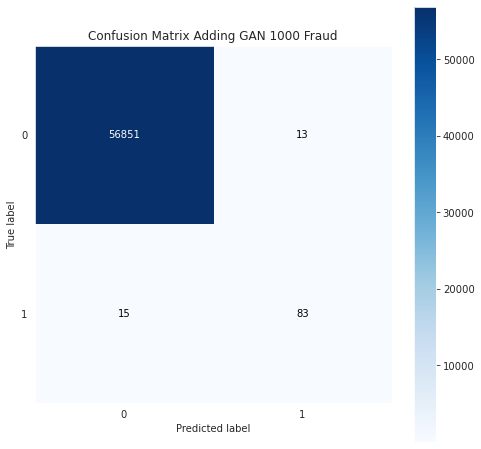

In [23]:
plot_cm(y_test, y_pred_gen_1000, 'Adding GAN 1000 Fraud')

## WGAN

In [31]:
from keras.optimizers import RMSprop
import tensorflow as tf
latent_dim= 32
data_dim = len(x_train.columns)
n_classes = len(np.unique(y_train))
optimizer_wgan = RMSprop(lr=0.00001)

# %% --------------------------------------- Set Seeds -----------------------------------------------------------------

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
weight_init = glorot_normal(seed=SEED)


# %% --------------------------------------- G D-----------------------------------------------------------------
def generator_wgan():

    noise = Input(shape=(latent_dim,))
    
    x = Dense(64, kernel_initializer=weight_init)(noise)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(256, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    # tanh is removed since we are not dealing with normalized image data
    out = Dense(data_dim, kernel_initializer=weight_init)(x)
    
    model = Model(inputs=noise, outputs=out)
    
    return model


def discriminator_wgan():
    data = Input(shape=data_dim)
    x = Dense(256, kernel_initializer=weight_init)(data)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(64, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    # remove sigmoid for D in WGAN
    out = Dense(1, kernel_initializer=weight_init)(x)

    model = Model(inputs=data, outputs=out)
    
    # RMSprop optimizer, w_loss
    model.compile(optimizer=optimizer_wgan, loss=w_loss)
    return model


def w_loss(y, y_pred):
    return tf.reduce_mean(tf.multiply(y, y_pred))

# def w_loss(y, y_pred):
#     return K.mean(y* y_pred)

def train_G_wgan(generator, discriminator):
    # Freeze the discriminator when training generator
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=optimizer_wgan, loss=w_loss)

    return model

# %% ----------------------------------- WGAN ----------------------------------------------------------------------
# modified from https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py
clip_value = 0.01
train_D = 2 # train D more than G

class WGAN:
    def __init__(self, g_model, d_model):
        self.z = latent_dim
        self.optimizer = optimizer_wgan

        self.generator = g_model
        self.discriminator = d_model

        self.train_G = train_G_wgan(self.generator, self.discriminator)
        self.loss_D, self.loss_G = [], []

    def train(self, data, batch_size=128, steps_per_epoch=50):    

        for epoch in range(steps_per_epoch):
            # Select a random batch of transactions data 
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]

            # generate a batch of new data
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data= self.generator.predict(noise)
            
            for _ in range(train_D):

                # Train D                
                loss_real = self.discriminator.train_on_batch(real_data, -np.ones(batch_size))
                loss_fake = self.discriminator.train_on_batch(fake_data, np.ones(batch_size))
                # loss_d = loss fake -  loss real: the wasserstein loss
                loss_d = 0.5 * np.add(loss_real, loss_fake)
                
                self.loss_D.append(loss_d)


                # clip the weight for D
                for l in self.discriminator.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                        l.set_weights(weights)

            # Train G
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            loss_G = self.train_G.train_on_batch(noise, -np.ones(batch_size))
            self.loss_G.append(loss_G)

            if (epoch + 1) * 10 % steps_per_epoch == 0:
                print('Steps (%d / %d): [Loss_D_real: %f, Loss_D_fake: %f] [loss_D: %f] [Loss_G: %f]' % 
                      (epoch+1, steps_per_epoch, loss_real, loss_fake, loss_d, loss_G))
#                   (epoch+1, steps_per_epoch, loss_real[0], loss_fake[0], loss_d[0], loss_G[0]))

#                 print('Steps (%d / %d): [Loss_D_real: %f, Loss_D_fake: %f, acc: %.2f%%] [Loss_G: %f]' %
#                   (epoch+1, steps_per_epoch, loss_real[0], loss_fake[0], loss_d, loss_G[0]))
#                 print('Steps (%d / %d): [Loss_D %f] [Loss_G: %f]' %
#                   (epoch+1, steps_per_epoch, self.loss_D, loss_G))


        return

# # %% -----------------------------------set up G D for WGAN ------------------------------------------------------------------
D_wgan = discriminator_wgan()
G_wgan  = generator_wgan()

D_wgan.summary()
G_wgan.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               7936      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64)               

In [32]:
wgan = WGAN(g_model=G_wgan, d_model=D_wgan)

EPOCHS = 25
X_train_fraud = x_train_fraud.to_numpy()
for epoch in range(EPOCHS):
    print('EPOCH # ', epoch + 1, '-' * 50)
    wgan.train(X_train_fraud, batch_size=128, steps_per_epoch=100)

EPOCH #  1 --------------------------------------------------
Steps (10 / 100): [Loss_D_real: -0.000276, Loss_D_fake: 0.000029] [loss_D: -0.000123] [Loss_G: -0.000016]
Steps (20 / 100): [Loss_D_real: -0.000335, Loss_D_fake: 0.000023] [loss_D: -0.000156] [Loss_G: -0.000009]
Steps (30 / 100): [Loss_D_real: -0.000618, Loss_D_fake: 0.000009] [loss_D: -0.000305] [Loss_G: 0.000004]
Steps (40 / 100): [Loss_D_real: -0.000969, Loss_D_fake: -0.000009] [loss_D: -0.000489] [Loss_G: 0.000023]
Steps (50 / 100): [Loss_D_real: -0.001407, Loss_D_fake: -0.000038] [loss_D: -0.000723] [Loss_G: 0.000049]
Steps (60 / 100): [Loss_D_real: -0.002074, Loss_D_fake: -0.000060] [loss_D: -0.001067] [Loss_G: 0.000076]
Steps (70 / 100): [Loss_D_real: -0.002538, Loss_D_fake: -0.000089] [loss_D: -0.001313] [Loss_G: 0.000109]
Steps (80 / 100): [Loss_D_real: -0.002984, Loss_D_fake: -0.000119] [loss_D: -0.001552] [Loss_G: 0.000139]
Steps (90 / 100): [Loss_D_real: -0.003541, Loss_D_fake: -0.000153] [loss_D: -0.001847] [Los

Steps (40 / 100): [Loss_D_real: -0.429590, Loss_D_fake: 0.070169] [loss_D: -0.179711] [Loss_G: -0.070635]
Steps (50 / 100): [Loss_D_real: -0.434347, Loss_D_fake: 0.074431] [loss_D: -0.179958] [Loss_G: -0.073998]
Steps (60 / 100): [Loss_D_real: -0.433043, Loss_D_fake: 0.075103] [loss_D: -0.178970] [Loss_G: -0.076999]
Steps (70 / 100): [Loss_D_real: -0.473358, Loss_D_fake: 0.081093] [loss_D: -0.196132] [Loss_G: -0.081815]
Steps (80 / 100): [Loss_D_real: -0.472709, Loss_D_fake: 0.087090] [loss_D: -0.192810] [Loss_G: -0.086016]
Steps (90 / 100): [Loss_D_real: -0.493896, Loss_D_fake: 0.089168] [loss_D: -0.202364] [Loss_G: -0.089716]
Steps (100 / 100): [Loss_D_real: -0.522904, Loss_D_fake: 0.094729] [loss_D: -0.214088] [Loss_G: -0.091661]
EPOCH #  9 --------------------------------------------------
Steps (10 / 100): [Loss_D_real: -0.525642, Loss_D_fake: 0.092483] [loss_D: -0.216580] [Loss_G: -0.095804]
Steps (20 / 100): [Loss_D_real: -0.429198, Loss_D_fake: 0.100233] [loss_D: -0.164482] [Lo

Steps (80 / 100): [Loss_D_real: -0.533130, Loss_D_fake: 0.283724] [loss_D: -0.124703] [Loss_G: -0.279952]
Steps (90 / 100): [Loss_D_real: -0.532214, Loss_D_fake: 0.290887] [loss_D: -0.120663] [Loss_G: -0.283596]
Steps (100 / 100): [Loss_D_real: -0.533592, Loss_D_fake: 0.290791] [loss_D: -0.121401] [Loss_G: -0.278192]
EPOCH #  16 --------------------------------------------------
Steps (10 / 100): [Loss_D_real: -0.495205, Loss_D_fake: 0.289416] [loss_D: -0.102894] [Loss_G: -0.282818]
Steps (20 / 100): [Loss_D_real: -0.522162, Loss_D_fake: 0.287018] [loss_D: -0.117572] [Loss_G: -0.282321]
Steps (30 / 100): [Loss_D_real: -0.532921, Loss_D_fake: 0.308699] [loss_D: -0.112111] [Loss_G: -0.288539]
Steps (40 / 100): [Loss_D_real: -0.503958, Loss_D_fake: 0.308547] [loss_D: -0.097706] [Loss_G: -0.298276]
Steps (50 / 100): [Loss_D_real: -0.525074, Loss_D_fake: 0.303890] [loss_D: -0.110592] [Loss_G: -0.293342]
Steps (60 / 100): [Loss_D_real: -0.506355, Loss_D_fake: 0.317411] [loss_D: -0.094472] [L

Steps (10 / 100): [Loss_D_real: -0.383561, Loss_D_fake: 0.405564] [loss_D: 0.011002] [Loss_G: -0.407586]
Steps (20 / 100): [Loss_D_real: -0.387783, Loss_D_fake: 0.400810] [loss_D: 0.006514] [Loss_G: -0.403273]
Steps (30 / 100): [Loss_D_real: -0.448515, Loss_D_fake: 0.402118] [loss_D: -0.023199] [Loss_G: -0.411359]
Steps (40 / 100): [Loss_D_real: -0.416860, Loss_D_fake: 0.412109] [loss_D: -0.002375] [Loss_G: -0.397570]
Steps (50 / 100): [Loss_D_real: -0.438488, Loss_D_fake: 0.403005] [loss_D: -0.017742] [Loss_G: -0.412979]
Steps (60 / 100): [Loss_D_real: -0.399133, Loss_D_fake: 0.394874] [loss_D: -0.002130] [Loss_G: -0.404954]
Steps (70 / 100): [Loss_D_real: -0.410238, Loss_D_fake: 0.397681] [loss_D: -0.006278] [Loss_G: -0.404110]
Steps (80 / 100): [Loss_D_real: -0.411013, Loss_D_fake: 0.407505] [loss_D: -0.001754] [Loss_G: -0.398273]
Steps (90 / 100): [Loss_D_real: -0.380009, Loss_D_fake: 0.413161] [loss_D: 0.016576] [Loss_G: -0.397908]
Steps (100 / 100): [Loss_D_real: -0.386745, Loss_

In [33]:
wgan.generator.save('wgan_generator.h5')

In [34]:
gen_1000wgan, x_train_gen_1000wgan, y_train_gen_1000wgan = gen_data(wgan.generator, 1000)
df_gen_1000wgan = pd.DataFrame(data=gen_1000wgan, index=None, columns=x_train.columns)
df_gen_1000wgan.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,12.014839,-6.305023,10.341335,-8.574209,8.299900,-9.044720,-4.633235,-11.389522,0.204499,-7.789335,...,0.975866,-0.014080,0.002197,-0.073361,-0.092199,-0.017477,0.106953,0.167389,0.107494,3.427012
std,2.801548,1.402232,2.401234,2.029324,1.945500,2.128428,1.141382,2.698648,0.297286,1.878873,...,0.359798,0.309235,0.372441,0.339191,0.301301,0.367543,0.265344,0.338120,0.396265,0.842888
min,4.049931,-11.222009,3.486689,-15.068597,2.739768,-16.394028,-8.617829,-20.925287,-1.078363,-14.348653,...,-0.084793,-0.914717,-1.099021,-1.171458,-0.924914,-1.043308,-0.764414,-1.107698,-1.326581,1.401648
25%,9.999061,-7.196817,8.626605,-9.757539,6.917021,-10.372511,-5.322743,-13.013300,0.008828,-8.923686,...,0.726711,-0.233750,-0.253383,-0.290629,-0.300965,-0.269029,-0.079615,-0.061865,-0.155170,2.834129
50%,11.807904,-6.215917,10.205181,-8.455754,8.195798,-8.812211,-4.535729,-11.154415,0.200554,-7.562764,...,0.960777,-0.014733,-0.005370,-0.069215,-0.107100,-0.052621,0.096420,0.168851,0.125779,3.344017
75%,13.763011,-5.354254,11.860113,-7.109643,9.497823,-7.527036,-3.848781,-9.431325,0.409282,-6.445704,...,1.200804,0.187754,0.240286,0.136887,0.120294,0.216406,0.272310,0.394001,0.376652,3.947572
max,21.611126,-2.239507,18.201218,-2.895845,14.578374,-3.071097,-1.530158,-3.991794,1.102077,-2.510722,...,2.296494,1.050034,1.329247,0.914874,0.953445,1.582470,0.948782,1.246364,1.279843,6.344531


In [35]:
y_pred_gen_1000wgan = XGBC_model_predit(x_train_gen_1000wgan, y_train_gen_1000wgan)
check_performance(y_test, y_pred_gen_1000wgan)

Accuracy:  0.9995435553526912
Precision:  0.8673469387755102
Recall:  0.8673469387755102
F1 score:  0.8673469387755102
ROC AUC score:  0.9335591615655828


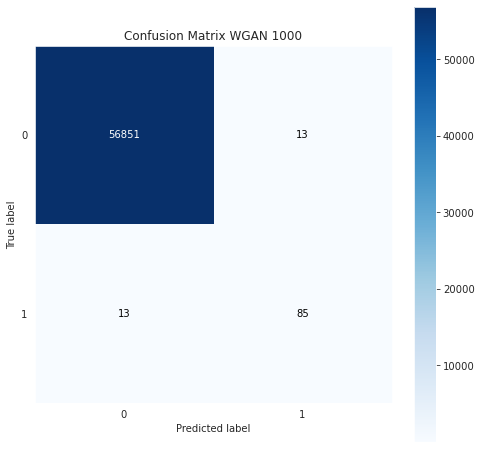

In [36]:
plot_cm(y_test, y_pred_gen_1000wgan, 'WGAN 1000')

## WGAN-GP  
modify WGAN loss function

In [40]:
latent_dim= 32
data_dim = len(x_train.columns)
n_classes = len(np.unique(y_train))
batch_size=128

# %% --------------------------------------- Set Seeds -----------------------------------------------------------------

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
weight_init = glorot_normal(seed=SEED)

# %% --------------------------------------- WGAN_GP G D-----------------------------------------------------------------
# https://github.com/keras-team/keras-io/blob/master/examples/generative/wgan_gp.py
    
def generator_wgan_gp():

    noise = Input(shape=(latent_dim,))
    
    x = Dense(64, kernel_initializer=weight_init)(noise)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(256, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    # tanh is removed since we are not dealing with normalized image data
    out = Dense(data_dim, kernel_initializer=weight_init)(x)
    
    model = Model(inputs=noise, outputs=out)
    
    return model


def discriminator_wgan_gp():
    data = Input(shape=data_dim)
    x = Dense(256, kernel_initializer=weight_init)(data)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(64, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

    out = Dense(1, kernel_initializer=weight_init)(x)
    model = Model(inputs=data, outputs=out)

    return model

##############################################################################

# %% ----------------------------------- WGAN_GP ----------------------------------------------------------------------

# gp_lambda = 5 # change lambda for gradient penalty

class WGAN_GP(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=2,
        gp_lambda=5,
    ):
        super(WGAN_GP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_lambda = gp_lambda

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_data, fake_data):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated data
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_data - real_data
        interpolated = real_data + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated data.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        # Get the batch size
        batch_size = tf.shape(real_data)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 1 extra steps
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_data = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_data, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_data, training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_score=real_logits, fake_score=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_data, fake_data)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_lambda

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake data using the generator
            generated_data = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake data
            gen_data_logits = self.discriminator(generated_data, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_data_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# Optimizer for both the networks

# generator_optimizer = Adam(learning_rate=0.00001)
# discriminator_optimizer = Adam(learning_rate=0.00001)

generator_optimizer = Adam(learning_rate=0.00001, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.00001, beta_1=0.5, beta_2=0.9)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_score, fake_score):
    real_loss = tf.reduce_mean(real_score)
    fake_loss = tf.reduce_mean(fake_score)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(fake_score):
    return -tf.reduce_mean(fake_score)


d_model = discriminator_wgan_gp()
g_model = generator_wgan_gp()


# Get the wgan model
wgan_gp = WGAN_GP(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim,
    discriminator_extra_steps=2,
)

# Compile the wgan model
wgan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Epochs to train
epochs = 1200
X_train_fraud = x_train_fraud.to_numpy()
wgan_gp.fit(X_train_fraud, batch_size=128, epochs=epochs)

Epoch 1/1200
4/4 [==============================] - 0s 11ms/step - d_loss: 51.8762 - g_loss: -0.0168
Epoch 2/1200
4/4 [==============================] - 0s 10ms/step - d_loss: 51.0969 - g_loss: -0.0048
Epoch 3/1200
4/4 [==============================] - 0s 10ms/step - d_loss: 46.8410 - g_loss: -0.0324
Epoch 4/1200
4/4 [==============================] - 0s 10ms/step - d_loss: 45.9880 - g_loss: -0.0490
Epoch 5/1200
4/4 [==============================] - 0s 11ms/step - d_loss: 43.0220 - g_loss: -0.0327
Epoch 6/1200
4/4 [==============================] - 0s 10ms/step - d_loss: 41.3529 - g_loss: -0.0263
Epoch 7/1200
4/4 [==============================] - 0s 10ms/step - d_loss: 40.1561 - g_loss: -0.0232
Epoch 8/1200
4/4 [==============================] - 0s 10ms/step - d_loss: 37.3178 - g_loss: -0.0380
Epoch 9/1200
4/4 [==============================] - 0s 17ms/step - d_loss: 35.0866 - g_loss: -0.0322
Epoch 10/1200
4/4 [==============================] - 0s 16ms/step - d_loss: 34.8189 - g_los

Epoch 161/1200
4/4 [==============================] - 0s 19ms/step - d_loss: -1.4087 - g_loss: -0.1184
Epoch 162/1200
4/4 [==============================] - 0s 15ms/step - d_loss: -1.5616 - g_loss: -0.1131
Epoch 163/1200
4/4 [==============================] - 0s 16ms/step - d_loss: -1.3967 - g_loss: -0.1145
Epoch 164/1200
4/4 [==============================] - 0s 15ms/step - d_loss: -1.3756 - g_loss: -0.1225
Epoch 165/1200
4/4 [==============================] - 0s 15ms/step - d_loss: -1.4498 - g_loss: -0.1234
Epoch 166/1200
4/4 [==============================] - 0s 15ms/step - d_loss: -1.5798 - g_loss: -0.1221
Epoch 167/1200
4/4 [==============================] - 0s 14ms/step - d_loss: -1.7636 - g_loss: -0.1153
Epoch 168/1200
4/4 [==============================] - 0s 16ms/step - d_loss: -1.5992 - g_loss: -0.1199
Epoch 169/1200
4/4 [==============================] - 0s 12ms/step - d_loss: -1.7739 - g_loss: -0.1138
Epoch 170/1200
4/4 [==============================] - 0s 10ms/step - d_lo

4/4 [==============================] - 0s 10ms/step - d_loss: -1.7994 - g_loss: -0.3225
Epoch 320/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.8934 - g_loss: -0.3428
Epoch 321/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.7662 - g_loss: -0.3312
Epoch 322/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -2.1578 - g_loss: -0.3417
Epoch 323/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -2.2651 - g_loss: -0.3467
Epoch 324/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -2.0721 - g_loss: -0.3596
Epoch 325/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.6266 - g_loss: -0.3603
Epoch 326/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.6755 - g_loss: -0.3580
Epoch 327/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -2.0275 - g_loss: -0.3448
Epoch 328/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.7067 - g

4/4 [==============================] - 0s 10ms/step - d_loss: -1.5939 - g_loss: -0.7089
Epoch 478/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.6502 - g_loss: -0.6667
Epoch 479/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -2.1932 - g_loss: -0.6508
Epoch 480/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.8943 - g_loss: -0.7046
Epoch 481/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.3854 - g_loss: -0.6597
Epoch 482/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.7428 - g_loss: -0.6807
Epoch 483/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.9357 - g_loss: -0.6730
Epoch 484/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.8131 - g_loss: -0.6718
Epoch 485/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.8738 - g_loss: -0.6269
Epoch 486/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.5671 - g

4/4 [==============================] - 0s 10ms/step - d_loss: -1.0153 - g_loss: -0.7186
Epoch 636/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.4400 - g_loss: -0.6705
Epoch 637/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.4309 - g_loss: -0.6911
Epoch 638/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.3365 - g_loss: -0.7601
Epoch 639/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.5446 - g_loss: -0.6726
Epoch 640/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.4197 - g_loss: -0.6613
Epoch 641/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -2.0695 - g_loss: -0.6935
Epoch 642/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.4467 - g_loss: -0.7038
Epoch 643/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.5445 - g_loss: -0.7250
Epoch 644/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.0981 - g

4/4 [==============================] - 0s 10ms/step - d_loss: -1.3126 - g_loss: -0.4414
Epoch 794/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.7102 - g_loss: -0.4591
Epoch 795/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.9131 - g_loss: -0.4221
Epoch 796/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8923 - g_loss: -0.4259
Epoch 797/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8343 - g_loss: -0.4327
Epoch 798/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.7719 - g_loss: -0.4320
Epoch 799/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.5875 - g_loss: -0.4117
Epoch 800/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8853 - g_loss: -0.3595
Epoch 801/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.9933 - g_loss: -0.3745
Epoch 802/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8773 - g

4/4 [==============================] - 0s 10ms/step - d_loss: -0.8425 - g_loss: -0.0923
Epoch 952/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.6102 - g_loss: -0.0694
Epoch 953/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8453 - g_loss: -0.0815
Epoch 954/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.7037 - g_loss: -0.0776
Epoch 955/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.0256 - g_loss: -0.0636
Epoch 956/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8230 - g_loss: -0.0663
Epoch 957/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8004 - g_loss: -0.0959
Epoch 958/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.8902 - g_loss: -0.0695
Epoch 959/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.7926 - g_loss: -0.0620
Epoch 960/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -1.1427 - g

4/4 [==============================] - 0s 15ms/step - d_loss: -0.8463 - g_loss: -0.1778
Epoch 1109/1200
4/4 [==============================] - 0s 19ms/step - d_loss: -1.5459 - g_loss: -0.1738
Epoch 1110/1200
4/4 [==============================] - 0s 24ms/step - d_loss: -0.9187 - g_loss: -0.1603
Epoch 1111/1200
4/4 [==============================] - 0s 18ms/step - d_loss: -0.9517 - g_loss: -0.1510
Epoch 1112/1200
4/4 [==============================] - 0s 16ms/step - d_loss: -0.2600 - g_loss: -0.1683
Epoch 1113/1200
4/4 [==============================] - 0s 11ms/step - d_loss: -1.1123 - g_loss: -0.1383
Epoch 1114/1200
4/4 [==============================] - 0s 11ms/step - d_loss: -0.6816 - g_loss: -0.1506
Epoch 1115/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.7617 - g_loss: -0.1753
Epoch 1116/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0.9256 - g_loss: -0.1633
Epoch 1117/1200
4/4 [==============================] - 0s 10ms/step - d_loss: -0

In [41]:
wgan_gp.generator.save('wgan_gp_generator.h5')

In [42]:
# generate 1000 more fraud
gen_1000_wgan_gp, x_train_gen_1000_wgan_gp, y_train_gen_1000_wgan_gp = gen_data(wgan_gp.generator, 1000)
df_gen_1000_wgan_gp = pd.DataFrame(data=gen_1000_wgan_gp, index=None, columns=x_train.columns)
df_gen_1000_wgan_gp.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,23.285898,-3.736352,2.997597,-6.250955,4.386627,-2.690249,-1.363962,-4.612177,0.660612,-2.170760,...,0.161842,0.240621,0.151653,0.064407,-0.196004,-0.021371,-0.057928,0.125946,-0.078475,0.935417
std,5.426660,1.026493,1.564539,2.113275,1.406841,1.277270,0.835166,1.663036,1.348746,1.228492,...,0.464864,0.807718,0.685435,0.585355,0.514275,0.587829,0.520005,0.846364,0.856760,0.793710
min,10.050900,-8.100610,-0.453291,-13.860250,0.889702,-7.325989,-4.856511,-10.718233,-2.863583,-6.186068,...,-1.509552,-2.064033,-1.781631,-1.671867,-1.546942,-1.756543,-1.656567,-2.476619,-2.983893,-1.248760
25%,19.338709,-4.390446,1.864912,-7.514736,3.371391,-3.524099,-1.929833,-5.637193,-0.302777,-2.920360,...,-0.163455,-0.303049,-0.279954,-0.344180,-0.542387,-0.403878,-0.424682,-0.455132,-0.647239,0.365596
50%,22.991888,-3.658928,2.800085,-6.009765,4.278168,-2.549115,-1.293017,-4.384441,0.554528,-2.013049,...,0.161121,0.221696,0.154098,0.045523,-0.224998,-0.052052,-0.064129,0.150543,-0.042851,0.912836
75%,26.578759,-3.006803,3.940542,-4.746693,5.297742,-1.741142,-0.761045,-3.349066,1.551444,-1.325352,...,0.440837,0.813910,0.588534,0.428765,0.131469,0.369913,0.322693,0.712349,0.539105,1.453722
max,41.840462,-1.164650,8.482611,-1.707185,9.282091,0.280309,0.806470,-1.021128,5.115191,0.709693,...,1.620332,2.592486,2.288929,1.883580,1.720156,1.901813,1.642066,2.772267,2.604203,3.975319


In [43]:
y_pred_gen_1000_wgan_gp = XGBC_model_predit(x_train_gen_1000_wgan_gp, y_train_gen_1000_wgan_gp)
check_performance(y_test, y_pred_gen_1000_wgan_gp)

Accuracy:  0.9995962220427653
Precision:  0.8947368421052632
Recall:  0.8673469387755102
F1 score:  0.8808290155440415
ROC AUC score:  0.9335855402937765


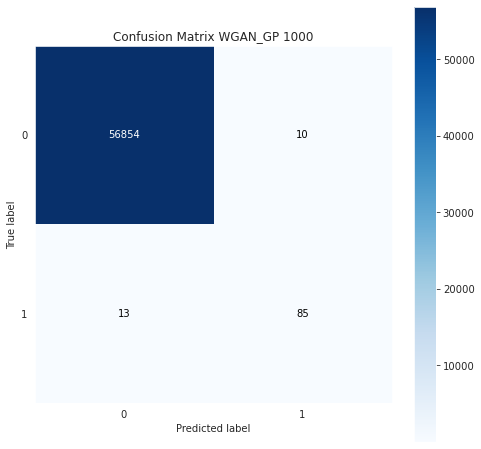

In [44]:
plot_cm(y_test, y_pred_gen_1000_wgan_gp, 'WGAN_GP 1000')